In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import scipy.integrate as spi
from matplotlib import animation
from scipy.integrate import odeint

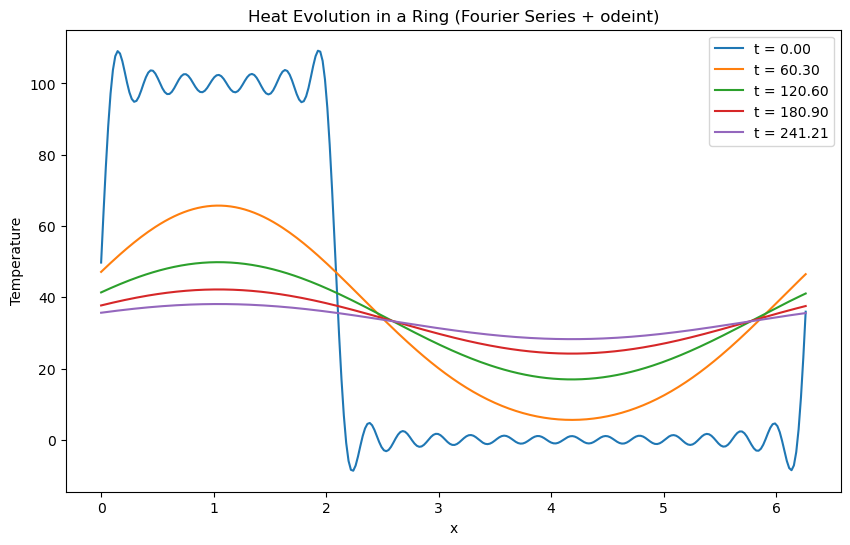

In [3]:
# Parameters
N_modes = 20      # No. of Fourier modes
L = 2 * np.pi     # Length of ring
alpha = 0.01      # Thermal diffusivity
T_max = 300.0     # Max time
n_times = 200     # Time steps
x_points = 300    # Spatial steps

x = np.linspace(0, L, x_points, endpoint=False)
t = np.linspace(0, T_max, n_times)


u0_x = np.zeros_like(x)
for i in range(x_points):
    if i<100:
        u0_x[i] = 100
    else:
        u0_x[i] = 0

# Compute initial Fourier coefficients
a0 = (1 / L) * np.trapz(u0_x, x)
a_k = np.zeros(N_modes)
b_k = np.zeros(N_modes)

for k in range(1, N_modes + 1):
    a_k[k - 1] = (2 / L) * np.trapz(u0_x * np.cos(k * x), x)
    b_k[k - 1] = (2 / L) * np.trapz(u0_x * np.sin(k * x), x)

# Single state vector
y0 = np.concatenate([[a0], a_k, b_k])

def heat_ode(y, t, alpha, N_modes):
    dydt = np.zeros_like(y)
    dydt[0] = 0  # a0 stays constant 
    for k in range(1, N_modes + 1):
        decay = -alpha * (k ** 2)
        dydt[k] = decay * y[k]    # a_k
        dydt[N_modes + k] = decay * y[N_modes + k]  # b_k
    return dydt

# Integrate over time
sol = odeint(heat_ode, y0, t, args=(alpha, N_modes))

# Solution
u_xt = np.zeros((len(t), len(x)))
for idx, yt in enumerate(sol):
    a0_t = yt[0]
    a_k_t = yt[1:N_modes + 1]
    b_k_t = yt[N_modes + 1:]
    u_xt[idx, :] = a0_t
    for k in range(1, N_modes + 1):
        u_xt[idx, :] += a_k_t[k - 1] * np.cos(k * x) + b_k_t[k - 1] * np.sin(k * x)

# Plot
plt.figure(figsize=(10, 6))
for i in range(0, len(t), len(t)//5):
    plt.plot(x, u_xt[i, :], label=f't = {t[i]:.2f}')
plt.xlabel('x')
plt.ylabel('Temperature')
plt.title('Heat Evolution in a Ring (Fourier Series + odeint)')
plt.legend()
plt.show()


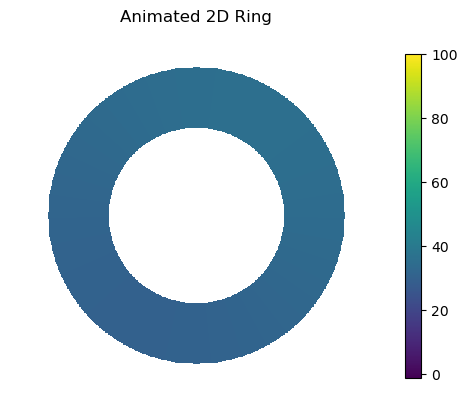

In [4]:
n = 500
x = np.linspace(-1.5, 1.5, n)
y = np.linspace(-1.5, 1.5, n)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
teta = np.arctan2(Y, X)


u_xt = np.zeros((len(t), 500,500))
for idx, yt in enumerate(sol):
    a0_t = yt[0]
    a_k_t = yt[1:N_modes + 1]
    b_k_t = yt[N_modes + 1:]
    u_xt[idx, :] = a0_t
    for k in range(1, N_modes + 1):
        u_xt[idx, :,:] += a_k_t[k - 1] * np.cos(k * teta) + b_k_t[k - 1] * np.sin(k * teta)

r_inner = 0.7
r_outer = 1.2
mask = (R >= r_inner) & (R <= r_outer)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(np.full_like(R, np.nan), extent=[-1.5, 1.5, -1.5, 1.5], origin='lower', cmap='viridis', vmin=-1, vmax=100)
plt.colorbar(im, shrink=0.7)
ax.set_title('Animated 2D Ring')
ax.axis('off')

# Animation function 
def update(frame):
    
    scalar_field = u_xt[frame]
    scalar_field_masked = np.where(mask, scalar_field, np.nan)
    im.set_data(scalar_field_masked)
    return [im]

# Create animation

ani = FuncAnimation(fig, update, frames=n_times, blit=True, interval=1000/30)

from matplotlib.animation import PillowWriter

writer = PillowWriter(fps=10)
ani.save("animation.gif", writer=writer)
plt.show()
